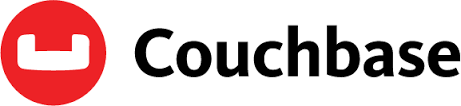

In [2]:
Image("images/_cb.png")

# An introduction to the Couchbase sub-document API in Python

In this notebook I will explore the usage of the Couchbase Key/Value and sub-document APIs in the Python SDK 2.x in order to highlight the similarities and differences between them.

The sub-document API was introduced in Couchbase Server version 4.5. The feature provides a means to send to or request from the Server only **portions** of a full document. 

This trades the cost of parsing the document on the server side for the benefit of reduced network traffic when reading (or adding) only small amounts of data relative to the total size of the document.

It also allows one to write data into a document without the necessity of reading the document first. Consider operations such as: array prepend/append, array index retrieval, field addition, etc.

My colleague David Maier provides more context and background in his blog post below, and there is also complete documentation available at Couchbase.com.

David's blog: http://blog.couchbase.com/2016/may/couchbase-server-45s-new-sub-document

Couchbase Python Library API docs: http://pythonhosted.org/couchbase/index.html

Download Couchbase: http://www.couchbase.com/nosql-databases/downloads


### First we set up our configuration

In [3]:
COUCHBASE_SERVER = "localhost"
COUCHBASE_BUCKET = "travel-sample"

import uuid
from IPython.display import display_javascript, display_html, display, Image
from IPython.core.display import HTML
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 200px; width:100%;"></div>'.format(self.uuid),
            raw=True
        )
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
          document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

### Next, we import necessary Couchbase libraries

In [4]:
from couchbase.bucket import Bucket
import couchbase.subdocument as SD
from couchbase import exceptions

### Connect to Couchbase

In [23]:
try:
    bucket = Bucket("couchbase://{0}/{1}".format(COUCHBASE_SERVER,COUCHBASE_BUCKET))
except exceptions.CouchbaseError as err:
    print("Couchbase error: {0}".format(err))
else:
    print("Successfully connected to Couchbase!")

Successfully connected to Couchbase!


### Retrieve one WHOLE document, by key, from the bucket

In [24]:
keyToRetrieve="airport_1284"
try:
    completeDocument = bucket.get(keyToRetrieve)
except Exception as err:
    if isinstance(err, exceptions.NotFoundError):
        print("Document %s not found in bucket: {0}".format(err.key, COUCHBASE_BUCKET))
except:
    print("Unhandled Exception encountered: {0}".format(err))

### Let's look at the return type of the get operation

In [7]:
print type(completeDocument)

<type 'ValueResult'>


Note that the returned **ValueResult** object from a get command contains also Couchbase Metadata.

### And what it is composed of...

In [8]:
print completeDocument

ValueResult<rc=0x0, key=u'airport_1284', value={u'city': u'Albi', u'tz': u'Europe/Paris', u'country': u'France', u'icao': u'LFCI', u'geo': {u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056}, u'faa': u'LBI', u'type': u'airport', u'id': 1284, u'airportname': u'Le Sequestre'}, cas=0xfc3052430100, flags=0x2000006>


We want only the **value** property to  get the true document body from Couchbase Server.

### Let's have a look at the document body

In [26]:
print completeDocument.value

{u'city': u'Albi', u'tz': u'Europe/Paris', u'country': u'France', u'icao': u'LFCI', u'geo': {u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056}, u'faa': u'LBI', u'type': u'airport', u'id': 1284, u'airportname': u'Le Sequestre'}


### So, now that we have seen what the API is like for a full document read, let's look at the sub-document API

In [40]:
# This field actually exists within the document we will retrieve.
fieldToRetrieve="geo"
# This field DOES NOT EXIST within the document we will retrieve.
missingFieldToRetrieve="foobar"
try:
    subDocument = bucket.lookup_in(keyToRetrieve, SD.get(fieldToRetrieve))
    subDocumentError = bucket.lookup_in(keyToRetrieve, SD.get(missingFieldToRetrieve))
except Exception as err:
    if isinstance(err, exceptions.NotFoundError):
        print("Document {0} not found in bucket: {0}".format(err.key, COUCHBASE_BUCKET))
except:
    print("Unhandled Exception encountered: {0}".format(err))
else:
    print("Success ")

Success 


It is worth nothing here that there is no Error/Exception that occurs if we request a sub-document lookup from a document associated with a Key that **DOES** exist within the database. Even if the **FIELD** we are seeking **DOES NOT** exist within the document itself. We have to handle the fact that even though we get a result to the operation from the Server that it may not contain the data we expected.

### Let's look at the return type of the subDocument operation

In [33]:
print type(subDocument)

<class 'couchbase.result.SubdocResult'>


### ... and what the return type of the subDocument operation is composed of

In [34]:
print subDocument

SubdocResult<rc=0x49[Could not execute one or more multi lookups or mutations], key='airport_1284', cas=0x0, specs=(Spec<GET, 'go'>,), results=[(63, None)]>


### We can access the subDocument by using a get command against the result by using the get() method, iteration, or direct index access

#### get()

In [35]:
print subDocument.get("geo")[1]

None


#### Iteration

In [36]:
for value in subDocument:
    print value

_SubdocPathNotFoundError_0x3F (generated, catch SubdocPathNotFoundError): <RC=0x3F[Sub-document path does not exist], OBJ='go'>

#### Index access

In [37]:
print subDocument[0]

_SubdocPathNotFoundError_0x3F (generated, catch SubdocPathNotFoundError): <RC=0x3F[Sub-document path does not exist]>